In [2]:
import os
import numpy as np
from radar_scenes.sequence import Sequence
from radar_scenes.labels import Label, ClassificationLabel
from collections import Counter

import pandas as pd
import os
import csv
import h5py
from pathlib import Path

In [ ]:
path_to_dataset = "RadarScenes"
sequence_file = os.path.join(path_to_dataset, "data", "sequences.json")

filename = os.path.join(path_to_dataset, "data", "sequence_137", "scenes.json")
sequence = Sequence.from_json(filename)

c = Counter(sequence.radar_data["label_id"])
for label_id, n in c.items():
    print("In the whole sequence, class {} occurred {} times".format(Label.label_id_to_name(label_id), n))

In the whole sequence, class STATIC occurred 1176747 times
In the whole sequence, class TRUCK occurred 5924 times
In the whole sequence, class LARGE_VEHICLE occurred 3375 times
In the whole sequence, class CAR occurred 27555 times
In the whole sequence, class OTHER occurred 684 times
In the whole sequence, class BUS occurred 1375 times
In the whole sequence, class BICYCLE occurred 1153 times


In [ ]:
sequence.radar_data

array([(29722480694020, 3,  8.102881 , -0.18412854,  4.9550447, -4.496616 , 0.11773991,  11.707217,  2.7193742, -725.0762 ,  -319.08514, b'0b0458d2125a8202199763723475df35', b'', 11),
       (29722480694020, 3,  6.16564  , -0.01072102, -2.1709626, -4.233369 , 0.10618235,   9.476427,  3.2437882, -722.83405,  -319.55884, b'cf9dce92cfac90a5b68f04a34343e437', b'', 11),
       (29722480694020, 3,  8.9705105, -0.06605706,  1.4818138, -4.327843 , 0.11401677,  12.223638,  3.9433978, -725.5647 ,  -320.3206 , b'4c4320fe7a4f7314412c737f115d67f1', b'', 11),
       ...,
       (29722617608977, 4, 40.320183 ,  0.83263886,  2.370472 ,  4.1750154, 0.14038816, -23.697906, 30.488836 ,  272.87473, -1546.6152 , b'8a9003efae7e9059bbe05f686cf7772c', b'', 11),
       (29722617608977, 4, 39.595337 ,  0.8446402 ,  9.703283 ,  4.1734133, 0.08727685, -23.553131, 29.631876 ,  272.09103, -1546.991  , b'dd5915cf8a1c81e3f05425549e4a4ca8', b'', 11),
       (29722617608977, 4, 43.180756 ,  1.0112518 , 10.036325 ,  4.8

In [ ]:
len(sequence.radar_data)

1216813

In [ ]:
sequence.radar_data.dtype

dtype([('timestamp', '<i8'), ('sensor_id', 'u1'), ('range_sc', '<f4'), ('azimuth_sc', '<f4'), ('rcs', '<f4'), ('vr', '<f4'), ('vr_compensated', '<f4'), ('x_cc', '<f4'), ('y_cc', '<f4'), ('x_seq', '<f4'), ('y_seq', '<f4'), ('uuid', 'S32'), ('track_id', 'S32'), ('label_id', 'u1')])

In [ ]:
def count_unique_objects(sequence: Sequence):
    """
    For each scene in the sequence, count how many different objects exist.
    Objects labeled as "clutter" are excluded from the counting, as well as the static detections.
    :param sequence: A measurement sequence
    :return: a list holding the number of unique objects for each scene
    """
    objects_per_scene = []
    for scene in sequence.scenes():
        track_ids = scene.radar_data["track_id"]
        label_ids = scene.radar_data["label_id"]

        valid_idx = np.where(label_ids != Label.STATIC.value)[0]
        unique_tracks = set(track_ids[valid_idx])
        objects_per_scene.append(len(unique_tracks))
    return objects_per_scene


def count_label_ids(sequence: Sequence):
    """
    Iterate over all scenes in a sequence and collect for each scene, how many detections belong to each class.
    :param sequence: a measurement sequence
    :return: A list of dictionaries. Each dict contains as key the label ids and as value the number of times this
    label_id occured.
    """
    # iterate over all scenes in the sequence and collect the number of labeled detections per class
    labels_per_scene = []
    for scene in sequence.scenes():
        label_ids = scene.radar_data["label_id"]
        c = Counter(label_ids)
        labels_per_scene.append(dict(c.items()))
    return labels_per_scene


print("\nCounting the number of unique dynamic objects in each scene:")
object_counts = count_unique_objects(sequence)
print("The most unique objects appear in scene {} in which {} different objects were labeled.".format(np.argmax(object_counts), object_counts[np.argmax(object_counts)]))


Counting the number of unique dynamic objects in each scene:
The most unique objects appear in scene 5780 in which 9 different objects were labeled.


---

In [ ]:
sequence = Sequence.from_json(filename)
labels_per_scene = count_label_ids(sequence)

# obtain labels for one specific scene:
scene_id = 1234
labels = labels_per_scene[scene_id]
for label_id, n in labels.items():
    print("In scene {}, class {} occurred {} times".format(scene_id, Label.label_id_to_name(label_id), n))

print("\n")
# count all labels at once
all_labels = sequence.radar_data["label_id"]
c = Counter(all_labels)
for label_id, n in c.items():
    print("In the whole sequence, class {} occurred {} times".format(Label.label_id_to_name(label_id), n))

# mapping to a reduced set of labels
c_label_ids = []
n_ignored = 0
for l in all_labels:
    mapped_label = ClassificationLabel.label_to_clabel(Label(l))
    if mapped_label is None:
        n_ignored += 1
        continue
    c_label_ids.append(mapped_label.value)

c = Counter(c_label_ids)
print("\nMapping to a reduced label set results in the following distribution:")
print("{} detections were ignored (mapped to None)".format(n_ignored))
for label_id, n in c.items():
    print("In the whole sequence, class {} occurred {} times".format(ClassificationLabel.label_id_to_name(label_id),
                                                                        n))

print("\nCounting the number of unique dynamic objects in each scene:")
object_counts = count_unique_objects(sequence)
print("The most unique objects appear in scene {} in which {} different objects were labeled.".format(
    np.argmax(object_counts), object_counts[np.argmax(object_counts)]))

In scene 1234, class STATIC occurred 161 times


In the whole sequence, class STATIC occurred 1176747 times
In the whole sequence, class TRUCK occurred 5924 times
In the whole sequence, class LARGE_VEHICLE occurred 3375 times
In the whole sequence, class CAR occurred 27555 times
In the whole sequence, class OTHER occurred 684 times
In the whole sequence, class BUS occurred 1375 times
In the whole sequence, class BICYCLE occurred 1153 times

Mapping to a reduced label set results in the following distribution:
684 detections were ignored (mapped to None)
In the whole sequence, class STATIC occurred 1176747 times
In the whole sequence, class LARGE_VEHICLE occurred 10674 times
In the whole sequence, class CAR occurred 27555 times
In the whole sequence, class TWO_WHEELER occurred 1153 times

Counting the number of unique dynamic objects in each scene:
The most unique objects appear in scene 5780 in which 9 different objects were labeled.


In [ ]:
# Count total number of points in the entire RadarScenes dataset
def count_total_points(dataset_path):
    """
    Count the total number of radar points across all sequences in the dataset.
    
    :param dataset_path: Path to the RadarScenes dataset
    :return: Total number of points
    """
    total_points = 0
    seq_count = 0
    
    data_dir = os.path.join(dataset_path, "data")
    
    for name in sorted(os.listdir(data_dir)):
        seq_dir = os.path.join(data_dir, name)
        if not os.path.isdir(seq_dir):
            continue
            
        h5_file = os.path.join(seq_dir, "radar_data.h5")
        if not os.path.isfile(h5_file):
            continue
            
        try:
            with h5py.File(h5_file, 'r') as h5:
                # Get the length from any dataset (they should all have the same length)
                if len(h5.keys()) > 0:
                    first_key = list(h5.keys())[1]
                    num_points = h5[first_key].shape[0]
                    total_points += num_points
                    seq_count += 1
                    print(f"Sequence {name}: {num_points:,} points")
        except Exception as e:
            print(f"Error reading {h5_file}: {e}")
            continue
    
    print(f"\n{'='*60}")
    print(f"Total sequences processed: {seq_count}")
    print(f"Total radar points in dataset: {total_points:,}")
    print(f"{'='*60}")
    
    return total_points

# Count points in the entire dataset
dataset_path = "RadarScenes"
total_points = count_total_points(dataset_path)

Sequence sequence_1: 555,979 points
Sequence sequence_10: 1,761,442 points
Sequence sequence_100: 633,771 points
Sequence sequence_101: 1,240,954 points
Sequence sequence_102: 1,009,955 points
Sequence sequence_103: 158,709 points
Sequence sequence_104: 1,291,398 points
Sequence sequence_105: 1,071,716 points
Sequence sequence_106: 887,467 points
Sequence sequence_107: 1,559,590 points
Sequence sequence_108: 1,467,242 points
Sequence sequence_109: 1,916,399 points
Sequence sequence_11: 318,397 points
Sequence sequence_110: 1,505,292 points
Sequence sequence_111: 280,042 points
Sequence sequence_112: 1,316,538 points
Sequence sequence_113: 1,854,118 points
Sequence sequence_114: 853,612 points
Sequence sequence_115: 1,116,240 points
Sequence sequence_116: 123,375 points
Sequence sequence_117: 1,865,463 points
Sequence sequence_118: 1,979,932 points
Sequence sequence_119: 1,348,180 points
Sequence sequence_12: 488,757 points
Sequence sequence_120: 510,642 points
Sequence sequence_121: 19

---

In [ ]:
def export_radarscenes_to_csv(dataset_path, output_csv="radarscenes_points.csv"):
    """
    Export all radar points from the RadarScenes dataset to a CSV file.
    Each row represents a single point from the point cloud.
    
    :param dataset_path: Path to the RadarScenes dataset
    :param output_csv: Output CSV filename
    """
    # Define the columns based on the standard RadarScenes data structure
    columns = ['timestamp', 'sensor_id', 'range_sc', 'azimuth_sc', 'rcs', 'vr', 
               'vr_compensated', 'x_cc', 'y_cc', 'x_seq', 'y_seq', 'uuid', 
               'track_id', 'label_id']
    
    total_points_written = 0
    seq_count = 0
    
    data_dir = os.path.join(dataset_path, "data")
    
    # Open CSV file for writing
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header
        writer.writerow(columns)
        
        # Iterate through all sequences
        for name in sorted(os.listdir(data_dir)):
            seq_dir = os.path.join(data_dir, name)
            if not os.path.isdir(seq_dir):
                continue
                
            scenes_file = os.path.join(seq_dir, "scenes.json")
            if not os.path.isfile(scenes_file):
                continue
            
            try:
                # Load sequence using the RadarScenes library
                sequence = Sequence.from_json(scenes_file)
                radar_data = sequence.radar_data
                
                num_points = len(radar_data)
                
                # Write each point as a row
                for i in range(num_points):
                    row = [
                        int(radar_data['timestamp'][i]),
                        int(radar_data['sensor_id'][i]),
                        float(radar_data['range_sc'][i]),
                        float(radar_data['azimuth_sc'][i]),
                        float(radar_data['rcs'][i]),
                        float(radar_data['vr'][i]),
                        float(radar_data['vr_compensated'][i]),
                        float(radar_data['x_cc'][i]),
                        float(radar_data['y_cc'][i]),
                        float(radar_data['x_seq'][i]),
                        float(radar_data['y_seq'][i]),
                        radar_data['uuid'][i].decode('utf-8') if isinstance(radar_data['uuid'][i], bytes) else str(radar_data['uuid'][i]),
                        radar_data['track_id'][i].decode('utf-8') if isinstance(radar_data['track_id'][i], bytes) else str(radar_data['track_id'][i]),
                        int(radar_data['label_id'][i])
                    ]
                    writer.writerow(row)
                
                total_points_written += num_points
                seq_count += 1
                print(f"Processed {name}: {num_points:,} points (Total so far: {total_points_written:,})")
                
            except Exception as e:
                print(f"Error processing {scenes_file}: {e}")
                continue
    
    print(f"\n{'='*60}")
    print(f"CSV Export Complete!")
    print(f"Total sequences processed: {seq_count}")
    print(f"Total points written: {total_points_written:,}")
    print(f"Output file: {output_csv}")
    print(f"{'='*60}")
    
    return total_points_written

# Export the entire RadarScenes dataset to CSV
dataset_path = "RadarScenes"
output_csv = "radarscenes_points.csv"
total_points = export_radarscenes_to_csv(dataset_path, output_csv)

Processed sequence_1: 555,979 points (Total so far: 555,979)
Processed sequence_10: 1,761,442 points (Total so far: 2,317,421)
Processed sequence_100: 633,771 points (Total so far: 2,951,192)
Processed sequence_101: 1,240,954 points (Total so far: 4,192,146)
Processed sequence_102: 1,009,955 points (Total so far: 5,202,101)
Processed sequence_103: 158,709 points (Total so far: 5,360,810)
Processed sequence_104: 1,291,398 points (Total so far: 6,652,208)
Processed sequence_105: 1,071,716 points (Total so far: 7,723,924)
Processed sequence_106: 887,467 points (Total so far: 8,611,391)
Processed sequence_107: 1,559,590 points (Total so far: 10,170,981)
Processed sequence_108: 1,467,242 points (Total so far: 11,638,223)
Processed sequence_109: 1,916,399 points (Total so far: 13,554,622)
Processed sequence_11: 318,397 points (Total so far: 13,873,019)
Processed sequence_110: 1,505,292 points (Total so far: 15,378,311)
Processed sequence_111: 280,042 points (Total so far: 15,658,353)
Process

In [ ]:
def export_radarscenes_to_csv(dataset_path, output_csv="radarscenes_points.csv"):
    """
    Export all radar points from the RadarScenes dataset to a CSV file.
    Each row represents a single point from the point cloud.
    
    :param dataset_path: Path to the RadarScenes dataset
    :param output_csv: Output CSV filename
    """
    # Define the columns based on the standard RadarScenes data structure
    columns = ['timestamp', 'sensor_id', 'range_sc', 'azimuth_sc', 'rcs', 'vr', 
               'vr_compensated', 'x_cc', 'y_cc', 'x_seq', 'y_seq', 'uuid', 
               'track_id', 'label_id']
    
    total_points_written = 0
    seq_count = 0
    
    data_dir = os.path.join(dataset_path, "data")
    
    # Open CSV file for writing
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header
        writer.writerow(columns)
        
        # Iterate through all sequences
        for name in sorted(os.listdir(data_dir)):
            seq_dir = os.path.join(data_dir, name)
            if not os.path.isdir(seq_dir):
                continue
                
            scenes_file = os.path.join(seq_dir, "scenes.json")
            if not os.path.isfile(scenes_file):
                continue
            
            try:
                # Load sequence using the RadarScenes library
                sequence = Sequence.from_json(scenes_file)
                radar_data = sequence.radar_data
                
                num_points = len(radar_data)
                
                # Write each point as a row
                for i in range(num_points):
                    row = [
                        int(radar_data['timestamp'][i]),
                        int(radar_data['sensor_id'][i]),
                        float(radar_data['range_sc'][i]),
                        float(radar_data['azimuth_sc'][i]),
                        float(radar_data['rcs'][i]),
                        float(radar_data['vr'][i]),
                        float(radar_data['vr_compensated'][i]),
                        float(radar_data['x_cc'][i]),
                        float(radar_data['y_cc'][i]),
                        float(radar_data['x_seq'][i]),
                        float(radar_data['y_seq'][i]),
                        radar_data['uuid'][i].decode('utf-8') if isinstance(radar_data['uuid'][i], bytes) else str(radar_data['uuid'][i]),
                        radar_data['track_id'][i].decode('utf-8') if isinstance(radar_data['track_id'][i], bytes) else str(radar_data['track_id'][i]),
                        int(radar_data['label_id'][i])
                    ]
                    writer.writerow(row)
                
                total_points_written += num_points
                seq_count += 1
                print(f"Processed {name}: {num_points:,} points (Total so far: {total_points_written:,})")
                
            except Exception as e:
                print(f"Error processing {scenes_file}: {e}")
                continue
    
    print(f"\n{'='*60}")
    print(f"CSV Export Complete!")
    print(f"Total sequences processed: {seq_count}")
    print(f"Total points written: {total_points_written:,}")
    print(f"Output file: {output_csv}")
    print(f"{'='*60}")
    
    return total_points_written

# Export the entire RadarScenes dataset to CSV
dataset_path = "RadarScenes"
output_csv = "radarscenes_points.csv"
total_points = export_radarscenes_to_csv(dataset_path, output_csv)

---

In [24]:
df_radarscenes_interator = pd.read_csv("radarscenes_points.csv", chunksize=10_000_000)

df_radarscenes_1 = next(df_radarscenes_interator)
df_radarscenes_1.head()

/tmp/ipykernel_7630/425526561.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_radarscenes_1 = next(df_radarscenes_interator)


,timestamp,sensor_id,range_sc,azimuth_sc,rcs,vr,vr_compensated,x_cc,y_cc,x_seq,y_seq,uuid,track_id,label_id
0,156862647501,1,2.566963,-0.124031,-28.300673,0.009330,-0.417386,3.566967,-3.438166,-172.275452,-226.578384,daf7becf58f03c9ad3850fe7ed05ddcf,NaN,11
1,156862647501,1,2.096815,0.849328,-26.863953,-8.023678,0.043853,5.351263,-2.116543,-173.183823,-228.604523,0456ea9f7947f3c35af66ad546001e01,NaN,11
2,156862647501,1,3.338323,1.106456,-26.564907,-9.334642,-0.005208,6.765986,-2.104209,-174.411224,-229.308151,18e82fe436de2f94940b6ef011185ce8,NaN,11
3,156862659751,2,8.882484,1.156905,0.101503,-7.361293,0.244834,10.533686,5.161779,-174.245239,-237.550934,f458e5a88269a286959211a188573994,NaN,11
4,156862659751,2,9.479269,1.090472,-3.724234,-7.834501,0.193050,11.381632,5.069020,-175.029877,-237.885529,f323f4e2753522ec982e1bcb5db2197c,NaN,11


In [25]:
df_radarscenes_1.dtypes

timestamp           int64
sensor_id           int64
range_sc          float64
azimuth_sc        float64
rcs               float64
vr                float64
vr_compensated    float64
x_cc              float64
y_cc              float64
x_seq             float64
y_seq             float64
uuid               object
track_id           object
label_id            int64
dtype: object

In [ ]:
# Re-create the iterator with a fixed dtype for track_id to avoid DtypeWarning,
# and aggregate counts while keeping a running total for faster progress reporting.
from collections import Counter

total_counts = Counter()
total_points = 0

df_iter = pd.read_csv("radarscenes_points.csv", chunksize=10_000_000, dtype={'track_id': str}, low_memory=False)

for chunk_idx, chunk in enumerate(df_iter, start=1):
    vc = chunk['label_id'].value_counts()
    total_counts.update(vc.to_dict())
    total_points += int(vc.sum())
    print(f"Processed chunk {chunk_idx} (cumulative points: {total_points:,})", end='\r')

# show final totals with label names
print("\nTotal label counts across all chunks:")
for label_id, cnt in sorted(total_counts.items()):
    print(f"Class {label_id} ({Label.label_id_to_name(label_id)}): {cnt}")

print(f"\nTotal points counted: {total_points:,}")

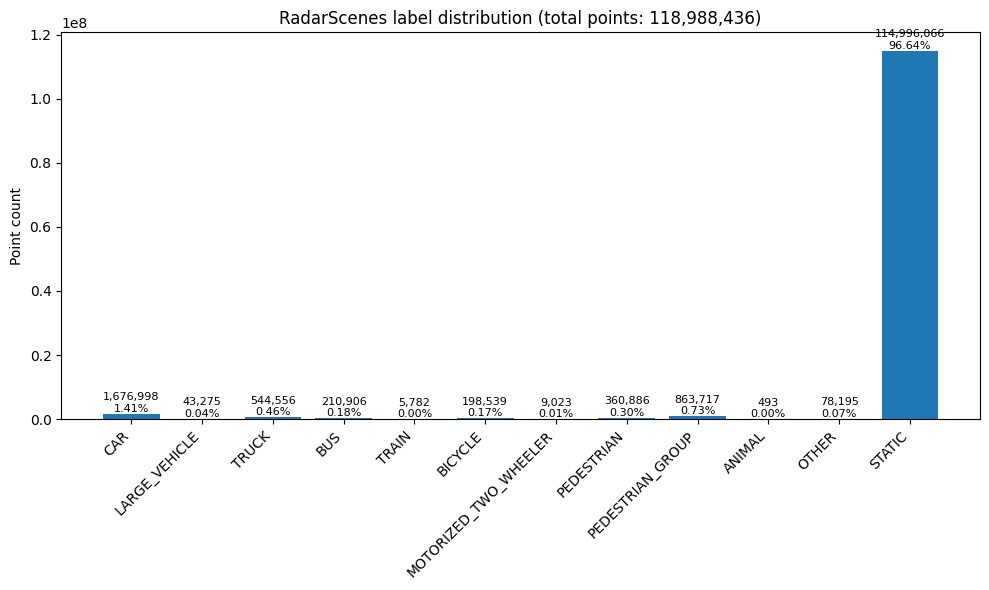

In [5]:
import matplotlib.pyplot as plt

# Use existing total_counts and total_points variables from the notebook
items = sorted(dict(total_counts).items())  # list of (label_id, count) sorted by label_id
label_ids = [lid for lid, _ in items]
labels = [Label.label_id_to_name(lid) for lid in label_ids]
values = [cnt for _, cnt in items]
total = total_points if 'total_points' in globals() else sum(values)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
bars = ax.bar(x, values, color='C0')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Point count')
ax.set_title(f'RadarScenes label distribution (total points: {total:,})')

# annotate counts and percentages above bars
for xi, bar, val in zip(x, bars, values):
    pct = val / total * 100 if total else 0
    ax.text(xi, bar.get_height(), f'{val:,}\n{pct:.2f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

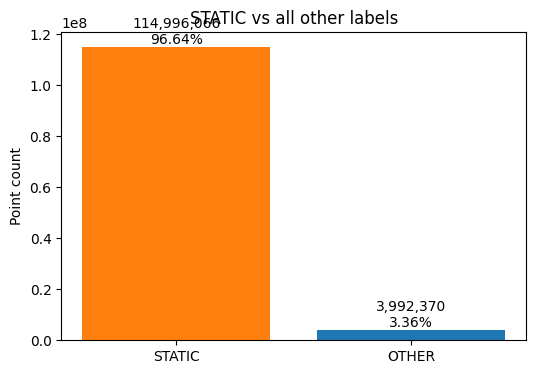

In [17]:
# Bar plot: one bar for STATIC, one for all other labels combined.
static_id = Label.STATIC.value if hasattr(Label, "STATIC") else 11
static_count = int(total_counts.get(static_id, 0))
total = total_points if 'total_points' in globals() else sum(total_counts.values())
other_count = int(total - static_count)

fig, ax2 = plt.subplots(figsize=(6, 4))
bars = ax2.bar(['STATIC', 'OTHER'], [static_count, other_count], color=['C1', 'C0'])
ax2.set_ylabel('Point count')
ax2.set_title('STATIC vs all other labels')

# annotate counts and percentages
for b, cnt in zip(bars, [static_count, other_count]):
    pct = cnt / total * 100 if total else 0
    ax2.text(b.get_x() + b.get_width() / 2, b.get_height(), f'{cnt:,}\n{pct:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

---

Filtered points (<=50m): 7,693,223 / 10,000,000
Total points (<=50m): 7,693,223
Noise points (<=50m): 7,340,618 (95.4%)

Per-class instance summary (annotated objects only, <=50m):
                           num_instances  total_points  avg_pts_per_instance  std_pts_per_instance  median_pts_per_instance  min_pts_per_instance  max_pts_per_instance
label_id                                                                                                                                                               
3: busses                            413          5689             13.774818             11.371705                     12.0                     1                    62
2: trucks                           7513         70206              9.344603              6.425360                      9.0                     1                    55
1: large vehicles                    723          6120              8.464730              8.391878                      6.0                     1  

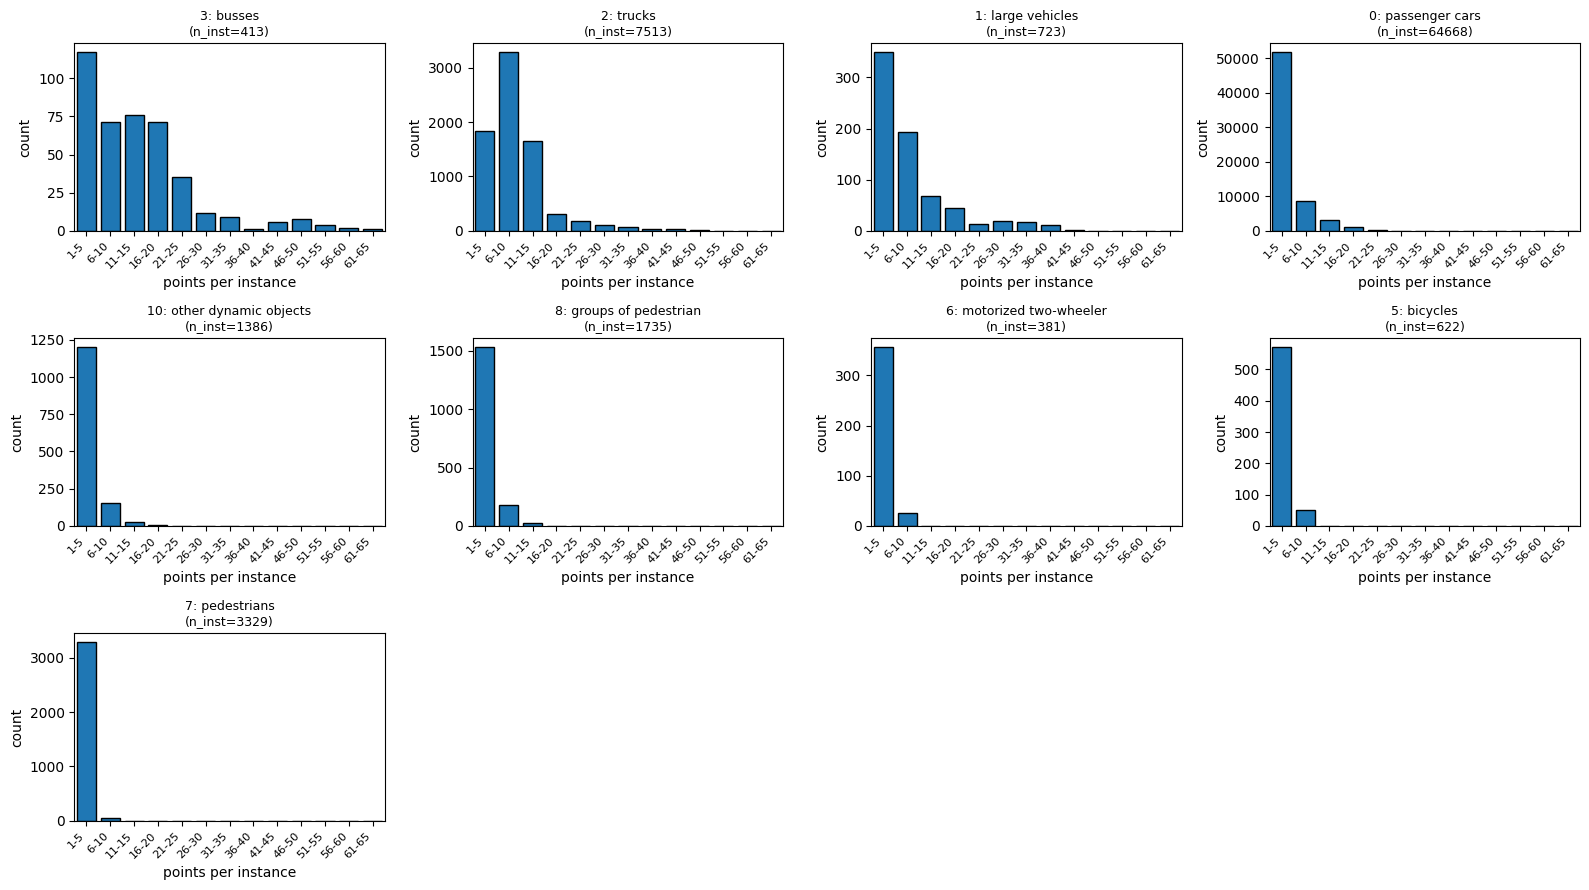

In [27]:
# Remake analysis for points up to 50 m from origin (XY plane)

# Copy loaded dataframe
df = df_radarscenes_1.copy()

# Compute distance from origin in XY plane and filter
df["dist"] = np.hypot(df['x_cc'].to_numpy(), df['y_cc'].to_numpy())
df = df[df["dist"] <= 50.0].reset_index(drop=True)

print(f"Filtered points (<=50m): {len(df):,} / {len(df_radarscenes_1):,}")

# Ensure instance_token is string and mark empty/missing
df['track_id'] = df['track_id'].fillna('').astype(str)

# Separate annotated objects (have instance_token) from noise
annotated_mask = (df['label_id'] != 11) & (df['track_id'] != '')

# Counts per instance
inst_counts = (
    df[annotated_mask]
    .groupby(['timestamp', 'label_id', 'track_id'])
    .size()
    .reset_index(name='pts_per_instance')
)

# Summary per annotation class (include std)
summary = (
    inst_counts
    .groupby('label_id')['pts_per_instance']
    .agg(
        num_instances='count',
        total_points='sum',
        avg_pts_per_instance='mean',
        std_pts_per_instance='std',
        median_pts_per_instance='median',
        min_pts_per_instance='min',
        max_pts_per_instance='max'
    )
    .fillna({'std_pts_per_instance': 0})
    .sort_values('avg_pts_per_instance', ascending=False)
)

# Map label ids to human-readable names
label_name_map = {
    0: 'passenger cars',
    1: 'large vehicles',
    2: 'trucks',
    3: 'busses',
    4: 'trains',
    5: 'bicycles',
    6: 'motorized two-wheeler',
    7: 'pedestrians',
    8: 'groups of pedestrian',
    9: 'animals',
    10: 'other dynamic objects',
    11: 'static environment'
}

# Create display mapping (e.g. "0: passenger cars") for printing, without changing numeric index used below
display_map = {lid: f"{lid}: {label_name_map.get(lid, 'unknown')}" for lid in summary.index}

# Noise stats
noise_count = (df['label_id'] == 11).sum()
total_points = len(df)

print(f"Total points (<=50m): {total_points:,}")
print(f"Noise points (<=50m): {noise_count:,} ({noise_count/total_points:.1%})\n")

print("Per-class instance summary (annotated objects only, <=50m):")
print(summary.rename(index=display_map).to_string())

# Overall stats across annotated instances
if not inst_counts.empty:
    overall_avg = inst_counts['pts_per_instance'].mean()
    overall_std = inst_counts['pts_per_instance'].std(ddof=0)
else:
    overall_avg = 0.0
    overall_std = 0.0

print(f"\nOverall average points per annotated instance (<=50m): {overall_avg:.2f}")
print(f"Overall std dev of points per annotated instance (<=50m): {overall_std:.2f}")

# Fixed-width (5) bins across all classes: 1-5, 6-10, 11-15, ...
classes = summary.index.tolist()  # keep numeric ids for filtering
n_classes = len(classes)
if n_classes == 0:
    print("No annotated classes to plot.")
else:
    # determine global max to create consistent bins
    if not inst_counts.empty:
        global_max = int(inst_counts['pts_per_instance'].max())
    else:
        global_max = 10
    # round up to next multiple of 5
    max_edge = ((global_max - 1) // 5 + 1) * 5
    edges = np.arange(1, max_edge + 5, 5)  # edges like [1,6,11,..., max_edge+1]
    labels = [f"{edges[i]}-{edges[i+1]-1}" for i in range(len(edges)-1)]

    cols = min(4, n_classes)
    rows = int(np.ceil(n_classes / cols))
    plt.figure(figsize=(cols * 4, rows * 3))
    for i, cls in enumerate(classes):
        ax = plt.subplot(rows, cols, i + 1)
        data = inst_counts.loc[inst_counts['label_id'] == cls, 'pts_per_instance']
        if data.empty:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center')
            ax.set_title(display_map.get(cls, str(cls)))
            ax.set_xticks([])
            continue

        counts, _ = np.histogram(data, bins=edges)
        x = np.arange(len(counts))
        ax.bar(x, counts, color='C0', edgecolor='k', width=0.8)
        n_inst = int(summary.loc[cls,'num_instances'])
        ax.set_title(f"{display_map.get(cls, str(cls))}\n(n_inst={n_inst})", fontsize=9)
        ax.set_xlabel('points per instance')
        ax.set_ylabel('count')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax.set_xlim(-0.5, len(counts)-0.5)
    plt.tight_layout()
    plt.show()

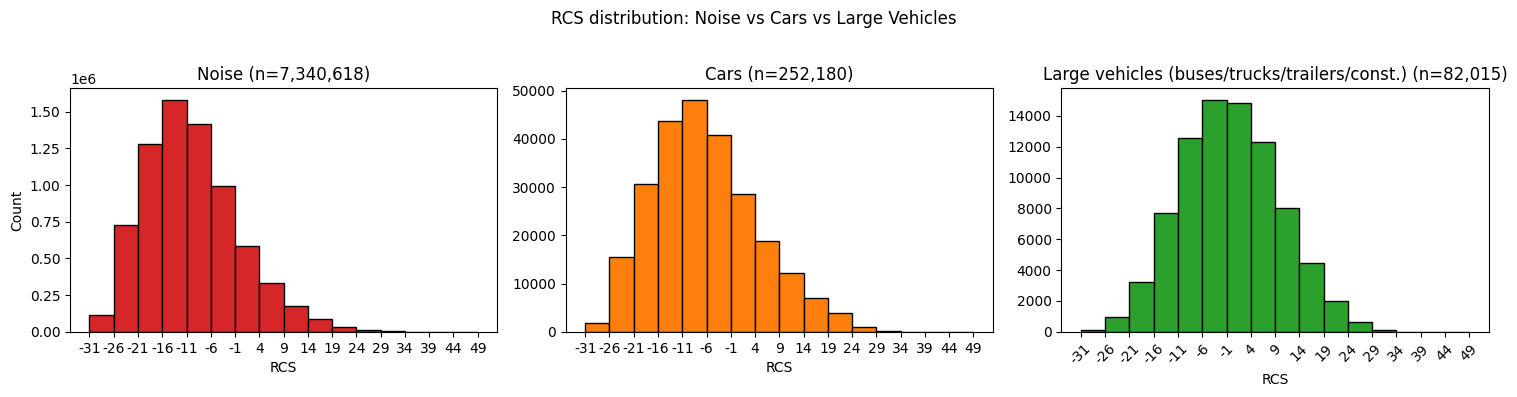

In [33]:
# Histogram of RCS for noise points plus cars and large vehicles (same x-axis, multiple plots)

# prefer existing `df` if defined by downstream cells; fallback to df_radarscenes_1
try:
    _df = df
except NameError:
    _df = df_radarscenes_1.copy()

noise_rcs = _df.loc[_df['label_id'] == 11, 'rcs'].dropna()

# cars
car_mask = _df['label_id'] == 0
car_rcs = _df.loc[car_mask, 'rcs'].dropna()

# large vehicles: buses, trucks, trailers, construction vehicles
large_mask = _df['label_id'].isin([1, 2, 3, 4])
large_rcs = _df.loc[large_mask, 'rcs'].dropna()

if noise_rcs.empty and car_rcs.empty and large_rcs.empty:
    print("No RCS values found for noise, cars or large vehicles.")
else:
    # determine common x-axis range across available series
    series_list = [s for s in (noise_rcs, car_rcs, large_rcs) if not s.empty]
    global_min = min(s.min() for s in series_list)
    global_max = max(s.max() for s in series_list)

    xmin = np.floor(global_min)
    xmax = np.ceil(global_max)

    if xmax - xmin < 2:
        bins = np.linspace(global_min, global_max, 20)
    else:
        bins = np.arange(xmin, xmax + 2, 5)

    # Do not share y-axis so each subplot auto-scales its Y to the data
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=False)

    axs[0].hist(noise_rcs, bins=bins, color='C3', edgecolor='k')
    axs[0].set_title(f"Noise (n={len(noise_rcs):,})")
    axs[0].set_xlabel('RCS')
    axs[0].set_ylabel('Count')

    axs[1].hist(car_rcs, bins=bins, color='C1', edgecolor='k')
    axs[1].set_title(f"Cars (n={len(car_rcs):,})")
    axs[1].set_xlabel('RCS')

    axs[2].hist(large_rcs, bins=bins, color='C2', edgecolor='k')
    axs[2].set_title(f"Large vehicles (buses/trucks/trailers/const.) (n={len(large_rcs):,})")
    axs[2].set_xlabel('RCS')

    # show common bin edges on x-axis for readability
    xticks = bins
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels([f"{e:.0f}" for e in xticks], rotation=45)

    plt.suptitle('RCS distribution: Noise vs Cars vs Large Vehicles')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


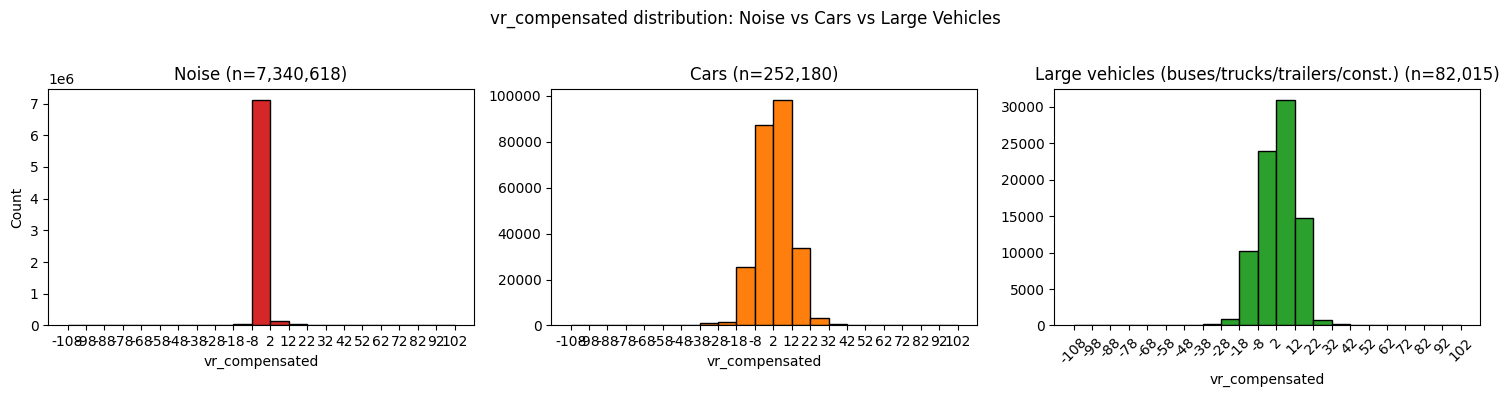

In [36]:
# Histogram of vr_compensated for noise points plus cars and large vehicles (same x-axis, multiple plots)

# prefer existing `df` if defined by downstream cells; fallback to df_radarscenes_1
try:
    _df = df
except NameError:
    _df = df_radarscenes_1.copy()

noise_vr_compensated = _df.loc[_df['label_id'] == 11, 'vr_compensated'].dropna()

# cars
car_mask = _df['label_id'] == 0
car_vr_compensated = _df.loc[car_mask, 'vr_compensated'].dropna()

# large vehicles: buses, trucks, trailers, construction vehicles
large_mask = _df['label_id'].isin([1, 2, 3, 4])
large_vr_compensated = _df.loc[large_mask, 'vr_compensated'].dropna()

if noise_vr_compensated.empty and car_vr_compensated.empty and large_vr_compensated.empty:
    print("No vr_compensated values found for noise, cars or large vehicles.")
else:
    # determine common x-axis range across available series
    series_list = [s for s in (noise_vr_compensated, car_vr_compensated, large_vr_compensated) if not s.empty]
    global_min = min(s.min() for s in series_list)
    global_max = max(s.max() for s in series_list)

    xmin = np.floor(global_min)
    xmax = np.ceil(global_max)

    if xmax - xmin < 2:
        bins = np.linspace(global_min, global_max, 5)
    else:
        bins = np.arange(xmin, xmax + 2, 10)

    # Do not share y-axis so each subplot auto-scales its Y to the data
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=False)

    axs[0].hist(noise_vr_compensated, bins=bins, color='C3', edgecolor='k')
    axs[0].set_title(f"Noise (n={len(noise_vr_compensated):,})")
    axs[0].set_xlabel('vr_compensated')
    axs[0].set_ylabel('Count')

    axs[1].hist(car_vr_compensated, bins=bins, color='C1', edgecolor='k')
    axs[1].set_title(f"Cars (n={len(car_vr_compensated):,})")
    axs[1].set_xlabel('vr_compensated')

    axs[2].hist(large_vr_compensated, bins=bins, color='C2', edgecolor='k')
    axs[2].set_title(f"Large vehicles (buses/trucks/trailers/const.) (n={len(large_vr_compensated):,})")
    axs[2].set_xlabel('vr_compensated')

    # show common bin edges on x-axis for readability
    xticks = bins
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels([f"{e:.0f}" for e in xticks], rotation=45)

    plt.suptitle('vr_compensated distribution: Noise vs Cars vs Large Vehicles')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

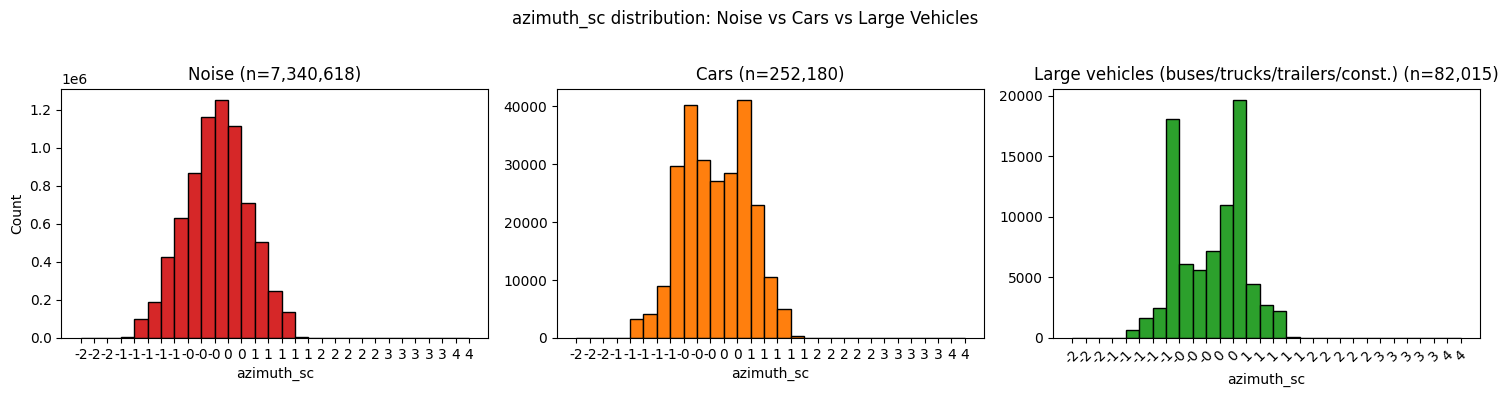

In [41]:
# Histogram of azimuth_sc for noise points plus cars and large vehicles (same x-axis, multiple plots)

# prefer existing `df` if defined by downstream cells; fallback to df_radarscenes_1
try:
    _df = df
except NameError:
    _df = df_radarscenes_1.copy()

noise_azimuth_sc = _df.loc[_df['label_id'] == 11, 'azimuth_sc'].dropna()

# cars
car_mask = _df['label_id'] == 0
car_azimuth_sc = _df.loc[car_mask, 'azimuth_sc'].dropna()

# large vehicles: buses, trucks, trailers, construction vehicles
large_mask = _df['label_id'].isin([1, 2, 3, 4])
large_azimuth_sc = _df.loc[large_mask, 'azimuth_sc'].dropna()

if noise_azimuth_sc.empty and car_azimuth_sc.empty and large_azimuth_sc.empty:
    print("No azimuth_sc values found for noise, cars or large vehicles.")
else:
    # determine common x-axis range across available series
    series_list = [s for s in (noise_azimuth_sc, car_azimuth_sc, large_azimuth_sc) if not s.empty]
    global_min = min(s.min() for s in series_list)
    global_max = max(s.max() for s in series_list)

    xmin = np.floor(global_min)
    xmax = np.ceil(global_max)

    if xmax - xmin < 2:
        bins = np.linspace(global_min, global_max, 5)
    else:
        bins = np.arange(xmin, xmax + 2, 0.2)

    # Do not share y-axis so each subplot auto-scales its Y to the data
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=False)

    axs[0].hist(noise_azimuth_sc, bins=bins, color='C3', edgecolor='k')
    axs[0].set_title(f"Noise (n={len(noise_azimuth_sc):,})")
    axs[0].set_xlabel('azimuth_sc')
    axs[0].set_ylabel('Count')

    axs[1].hist(car_azimuth_sc, bins=bins, color='C1', edgecolor='k')
    axs[1].set_title(f"Cars (n={len(car_azimuth_sc):,})")
    axs[1].set_xlabel('azimuth_sc')

    axs[2].hist(large_azimuth_sc, bins=bins, color='C2', edgecolor='k')
    axs[2].set_title(f"Large vehicles (buses/trucks/trailers/const.) (n={len(large_azimuth_sc):,})")
    axs[2].set_xlabel('azimuth_sc')

    # show common bin edges on x-axis for readability
    xticks = bins
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels([f"{e:.0f}" for e in xticks], rotation=45)

    plt.suptitle('azimuth_sc distribution: Noise vs Cars vs Large Vehicles')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

---